In [1]:
import math
import random
import numpy as np
from numpy import linalg

from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
from mesa.time import RandomActivation

#TODO: create a funtion that gets at what step 95% of the swarm has been stable for at least 10 steps
#TODO: create a batch runner that can get all this data v-quick
#TODO: create way to count area covered. Define area covered
#TODO: create rootsAgent
def area_covered(model):
    area=0
    for row in range(int(model.grid.height)):
        for col in range(int(model.grid.width)):
            if len(model.grid.get_neighbors((row,col),moore= True,include_center=True, radius=3))>1:
                area+=1
    return area
def percent_stable(model):
    agent_stabilities=[agent.stable for agent in model.schedule.agents]
    fraction=0
    for x in agent_stabilities:
        if x:
            fraction+=1
    return fraction/len(agent_stabilities)
def connections_perAgent(model):
    connections=[agent.num for agent in model.schedule.agents]
    return sum(connections)/len(connections)

def fiedler_eigenvalues(model):
    agents=model.schedule.agents
    dim=len(agents)
    adjMatrix=np.zeros((dim,dim))
    for x in agents:
        for y in x.neighbors:
            adjMatrix[x.unique_id,y.unique_id]=1
    degMatrix=np.zeros((dim,dim))
    for x in agents:
        degMatrix[x.unique_id,x.unique_id]=x.num
    lapMatrix=np.subtract(degMatrix,adjMatrix)
    eigenvals= linalg.eig(lapMatrix)[0]
    uniq_evals=[]
    connected_components=0
    for x in eigenvals:
        if int(x)==0:
            connected_components+=1
        if int(x) not in uniq_evals:
            uniq_evals.append(int(x))
    uniq_evals.sort()
    if len(uniq_evals)<2:
        return 0
    elif uniq_evals[1]==0:
        return connected_components
    elif uniq_evals[1]>=0:
        return 1
    else:
        return 0 #uniq_evals[1]

class SwarmModel(Model):


    def __init__(self, N, width, height, numNeighbors,swarmType):
        self.num_agents = N
        self.running = True
        if numNeighbors>N:
            numNeighbors=N
        self.numNeighbors=numNeighbors
        self.grid = MultiGrid(height, width, True)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Connections": connections_perAgent, "Stability": percent_stable, "Area": area_covered},
            agent_reporters={"NumNeighbors":"num", "Stable":"stable","Neighbors":"neighbors"}
        )
        # Create agents
        for i in range(self.num_agents):
            if swarmType=="Roots":
                a = RootsAgent(i, self)
                if i==0:
                    a.stable=True
                self.schedule.add(a)
            else:
                a = BasicAgent(i, self)
                self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.grid.width//2
            y = self.grid.height//2
            self.grid.place_agent(a, (x, y))

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        for i in range(n):
            self.step()


class BasicAgent(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.direction=(0,0)
        self.neighbors=[]
        self.num=0
        self.targetNeighbors=self.model.numNeighbors
        self.lowerBuffer=1
        self.upperBuffer=1
        self.stable=False

    def chooseDirection(self):
        #update neighbors
        #moore= include diagonals
        self.neighbors= self.model.grid.get_neighbors(self.pos,moore= True,include_center=True, radius=3)
        self.num=len(self.neighbors)-1

        if self.num>=self.targetNeighbors-self.lowerBuffer and self.num<=self.targetNeighbors+self.upperBuffer:
            #stay put
            #print("agent: %d stayed",self.unique_id)
            self.direction= (0,0)
        elif self.num==0:
            #return to center
            x=self.model.grid.width//2-self.pos[0]
            y=self.model.grid.height//2-self.pos[1]
            #self.stable=False
            self.direction= self.flattenDirection((x,y))
        elif self.num< self.targetNeighbors-self.lowerBuffer:
            #move toward neighbors
            avgPos=self.getAvgNeighborPos()
            x=avgPos[0]-self.pos[0]
            y=avgPos[1]-self.pos[1]
            #self.stable=False
            self.direction= self.flattenDirection((x,y))
        else:
            #move away from neighbors
            #print("neighbors:", self.neighbors)
            avgPos=self.getAvgNeighborPos()
            #print("pos:",self.pos)
            #print("pos:",avgPos)
            x=self.pos[0]-avgPos[0]
            y=self.pos[1]-avgPos[1]
            if x==0 and y==0:
                #move randomly
                self.direction=self.randomDirection()
            else:
                self.direction=self.flattenDirection((x,y))
    def randomDirection(self):
        x= random.randint(-1,1)
        y=random.randint(-1,1)
        return (x,y)
    def flattenDirection(self, newPos):
        x= newPos[0]
        y= newPos[1]
        if x>y:
            return (math.copysign(1,x),0)
        elif x<y:
            return(0,math.copysign(1,y))
        else:
            return(math.copysign(1,x),math.copysign(1,y))
        
    def getAvgNeighborPos(self):
        x=0
        y=0
        for neigh in self.neighbors:
            if neigh.unique_id==self.unique_id:
                pass
            else:
                x+=neigh.pos[0]
                y+=neigh.pos[1]
        return (x//self.num,y//self.num) 
    
    def move(self):
        self.chooseDirection()
        if self.direction== (0,0):
            self.stable=True
        else:
            self.stable=False
        x=self.pos[0]+self.direction[0]
        y=self.pos[1]+self.direction[1]
        new_position = (int(x),int(y))
        self.model.grid.move_agent(self, new_position)

    def step(self):
        self.move()
#----------------------------------------------------
class RootsAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.direction=(0,0)
        self.neighbors=[]
        self.num=0
        self.targetNeighbors=self.model.numNeighbors
        self.lowerBuffer=1
        self.upperBuffer=1
        self.stable=False
        self.parent= None
        self.parentDir=(0,0)
        self.parent_pos=(0,0)
        self.leader=False
        self.depth=0

    def getParent(self):
        tempParent=None
        for x in self.neighbors:
            if x.stable and x.targetNeighbors>0:
                if tempParent==None:
                    tempParent=x
                elif x.depth<tempParent.depth:
                    tempParent=x
        if tempParent==None:       
            return False
        else:
            self.parent=tempParent.unique_id
            self.parent_pos=tempParent.pos
            tempParent.targetNeighbors-=1
            self.depth= tempParent.depth+1
            self.parentDir=tempParent.direction
            return True
    def dirIsDiagonal(self):
        if abs(self.parentDir[0])==abs(self.parentDir[0]):
            return True
        return False
    def getMutatedDir(self):
        x=self.parentDir[0]
        y=self.parentDir[1]
        if self.dirIsDiagonal():
            choice=random.randint(0,2)
            if choice==0:
                x-=math.copysign(1,x)
            elif choice==1:
                y-=math.copysign(1,y)
            else:
                pass
        else:
            mutation=random.randint(-1,1)
            if abs(x)>abs(y):
                y+=mutation
            else:
                x+=mutation
        return (x,y)
    def lead(self):
        x= self.parentDir[0]
        y= self.parentDir[1]
        mutation=self.getMutatedDir()
        neighborpos=self.getAvgNeighborPos()
        neighbordir=self.flattenDirection((x-neighborpos[0],y-neighborpos[1]))
        x=x+mutation[0]-2*neighbordir[0]
        y=y+mutation[1]-2*neighbordir[1]
        self.direction=self.flattenDirection((x,y))
    def getLeaderPos(self):
        #gets the leader with the least neighbors
        leader=None
        for x in self.neighbors:
            if not x.stable and x.leader:
                #update x's neighbors
                x.neighbors= x.model.grid.get_neighbors(x.pos,moore= True,include_center=True, radius=3)
                x.num = len(x.neighbors)
                if leader==None:
                    leader=x
                elif x.num<leader.num:
                    leader=x
        return leader.pos

    def follow(self):
        leaderPos=self.getLeaderPos()
        x= leaderPos[0]-self.pos[0]
        y= leaderPos[1]-self.pos[1]
        self.direction=self.flattenDirection((x,y))

    def chooseDirection(self):
        self.neighbors= self.model.grid.get_neighbors(self.pos,moore= True,include_center=True, radius=3)
        self.num=len(self.neighbors)-1
        if not self.leader:
            if self.getParent():
                #become a leader
                self.leader=True
                self.lead()
            else:
                #become a follower
                self.follow()
        else:
            if self.parentDir==(0,0):
                while(self.direction==(0,0)):
                    self.direction=self.randomDirection()
            else:
                self.lead()

        
    
    def randomDirection(self):
        x= random.randint(-1,1)
        y=random.randint(-1,1)
        return (x,y)
    def flattenDirection(self, newPos):
        x= newPos[0]
        y= newPos[1]
        if x>y:
            return (math.copysign(1,x),0)
        elif x<y:
            return(0,math.copysign(1,y))
        else:
            return(math.copysign(1,x),math.copysign(1,y))
        
    def getAvgNeighborPos(self):
        x=0
        y=0
        for neigh in self.neighbors:
            if neigh.unique_id==self.unique_id:
                pass
            else:
                x+=neigh.pos[0]
                y+=neigh.pos[1]
        return (x//self.num,y//self.num) 
    def isInRange(self, new_pos):
        diffX=abs(new_pos[0]-self.parent_pos[0])
        diffY=abs(new_pos[1]-self.parent_pos[1])
        if diffX+diffY<=3:
            return True
        elif diffX==diffY==2:
            return True
        else:
            return False
    def move(self):
        if not self.stable:
            self.chooseDirection()
            x=self.pos[0]+self.direction[0]
            y=self.pos[1]+self.direction[1]
            new_position = (int(x),int(y))
            if self.leader and not self.isInRange(new_position):
                self.stable=True
            else:
                self.model.grid.move_agent(self, new_position)

    def step(self):
        self.move()


In [16]:
from mesa.batchrunner import BatchRunner
fixed_params = {"width": 50,
                "height": 50,
               "swarmType": "Basic",
               "N":50}
variable_params = {"numNeighbors": range(2, 20, 1)}

batch_run = BatchRunner(SwarmModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=10,
                        max_steps=100,
                        model_reporters={"Connections": connections_perAgent, "Stability": percent_stable, "Area": area_covered, "Fiedler": fiedler_eigenvalues})
batch_run.run_all()

50it [04:53,  1.18s/it]C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
180it [15:20,  1.02s/it]


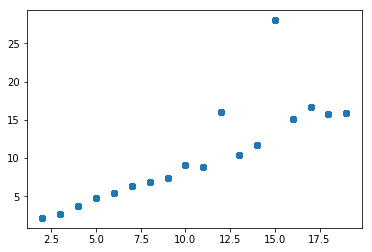

In [17]:
import matplotlib.pyplot as plt
basic_data= batch_run.get_model_vars_dataframe()
basic_data.head()
plt.scatter(basic_data.numNeighbors, basic_data.Connections)

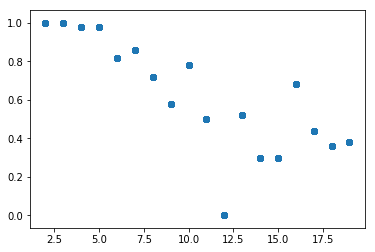

In [18]:
plt.scatter(basic_data.numNeighbors, basic_data.Stability)

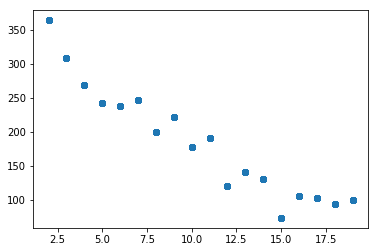

In [19]:
plt.scatter(basic_data.numNeighbors, basic_data.Area)

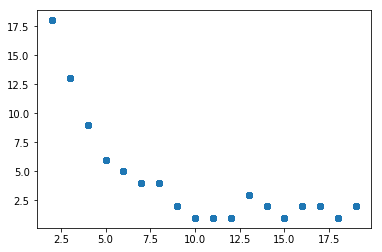

In [20]:
plt.scatter(basic_data.numNeighbors, basic_data.Fiedler)

In [21]:

fixed_params2 = {"width": 50,
                "height": 50,
               "swarmType": "Roots",
               "N":50}
variable_params2 = {"numNeighbors": range(2, 20, 1)}

batch_run = BatchRunner(SwarmModel,
                        fixed_parameters=fixed_params2,
                        variable_parameters=variable_params2,
                        iterations=10,
                        max_steps=100,
                        model_reporters={"Connections": connections_perAgent, "Stability": percent_stable, "Area": area_covered, "Fiedler": fiedler_eigenvalues})
batch_run.run_all()

0it [00:00, ?it/s]C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
180it [14:07,  1.01it/s]


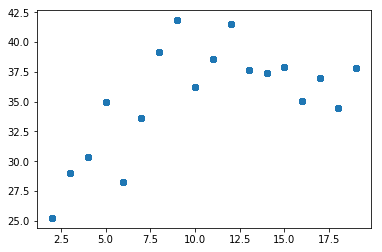

In [22]:
root_data= batch_run.get_model_vars_dataframe()
root_data.head()
plt.scatter(root_data.numNeighbors, root_data.Connections)

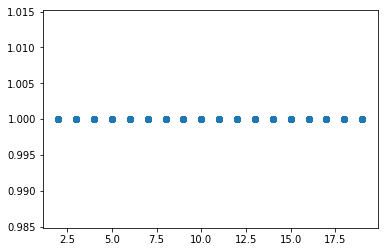

In [23]:
plt.scatter(root_data.numNeighbors, root_data.Stability)

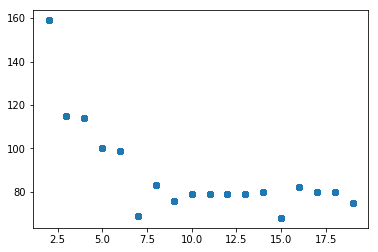

In [24]:
plt.scatter(root_data.numNeighbors, root_data.Area)

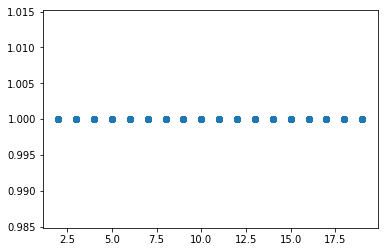

In [25]:
plt.scatter(root_data.numNeighbors, root_data.Fiedler)